In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pysal.model import mgwr

from urbana.constants import DIR_REPO, DIR_DATA

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
VARIABLE_TO_PREDICT = "Airbnb_Number"

In [5]:
sect = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.dropna(inplace=True)

Region with maximum value : 02_077


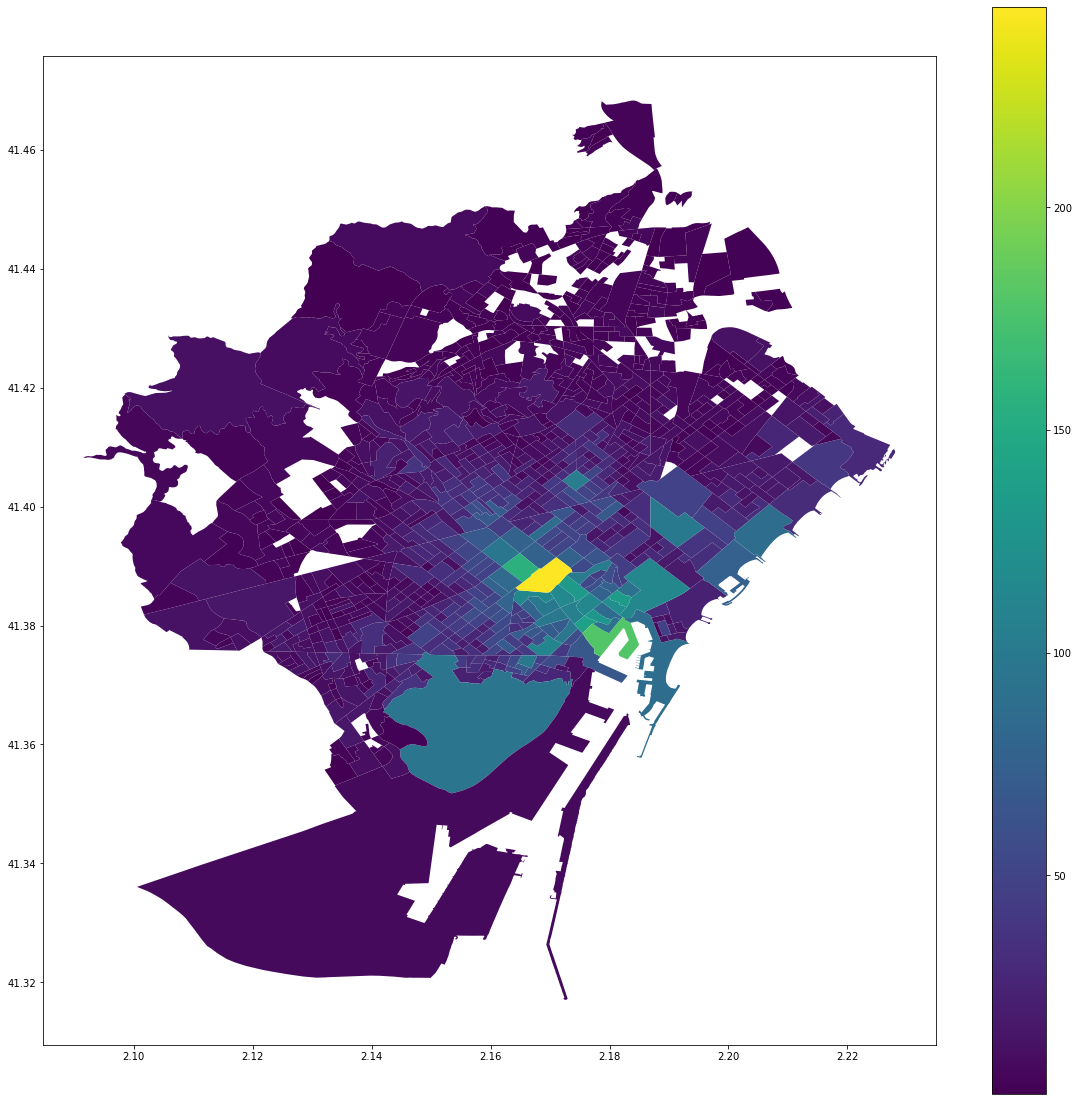

In [6]:
sect.plot(column=VARIABLE_TO_PREDICT, legend=True, figsize=(20, 20))
id_max_airbnb = sect["Airbnb_Number"].idxmax()
print("Region with maximum value : " + str(id_max_airbnb))

In [7]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "geometry",
    ],
    axis=1,
)
coords = np.column_stack([sect["geometry"].centroid.x, sect["geometry"].centroid.y])

geo_info = sect[["geometry"]]
geo_info["centroid"] = geo_info["geometry"].centroid

In [8]:
X_num = np.array(X)

X_std = (X_num - X_num.mean(axis=0)) / X_num.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

# GWR
All of the processes being modeled operate at the same spatial scale

In [9]:
%%time
gwr_selector = mgwr.sel_bw.Sel_BW(
    coords, y_std, X_std, fixed=False, spherical=True, multi=False
)
gwr_bw = gwr_selector.search()
print("For GWR, bandwith: " + str(gwr_bw))

For GWR, bandwith: 699.0
CPU times: user 2min 11s, sys: 57.3 s, total: 3min 9s
Wall time: 25.4 s


In [10]:
gwr_model = mgwr.gwr.GWR(coords, y_std, X_std, gwr_bw)
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 965
Number of covariates:                                                    79

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            149.209
Log-likelihood:                                                    -468.555
AIC:                                                               1095.110
AICc:                                                              1111.771
BIC:                                                              -5939.496
R2:                                                                   0.845
Adj. R2:                                                              0.832

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Text(0.5, 1.0, 'Local R2')

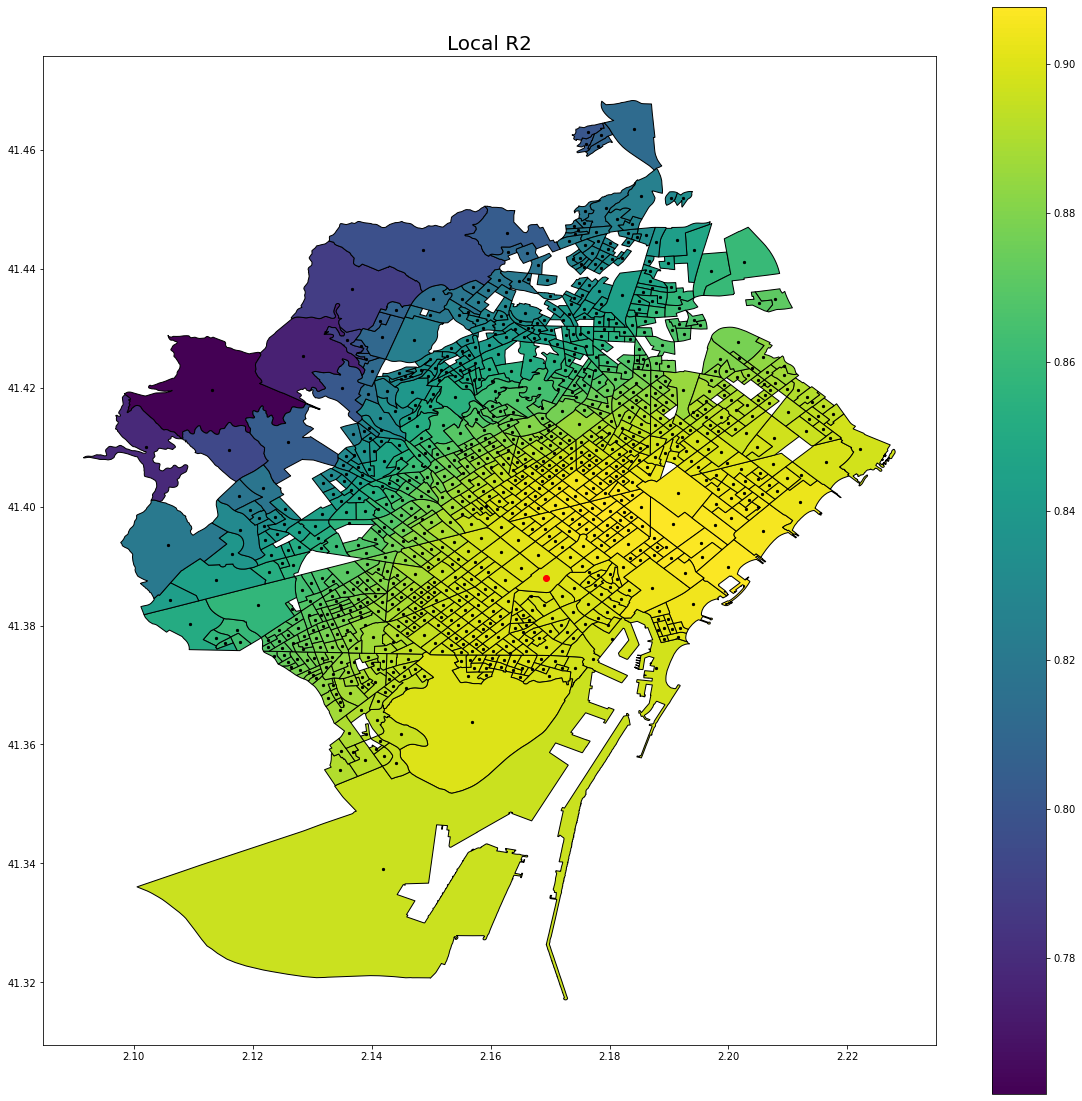

In [11]:
geo_info["Local_R2"] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(ax=ax, edgecolor="black", column="Local_R2", legend=True)
# geo_info.plot(ax=ax)
geo_info.centroid.plot(ax=ax, color="black", markersize=5)
sect[sect.index == id_max_airbnb].centroid.plot(ax=ax, color="red")

ax.set_title("Local R2", fontsize=20)

In [ ]:
# p-values computation
%time
p_vals_1000 = gwr_results.spatial_variability(gwr_selector)
print(p_vals_1000)

# MGWR
All of the processes being modeled **DO NOT** operate at the same spatial scale